## Hierarchical Context Dynamics

We would like in a 2 layer network designed for sequence learning (e.g. an RSM-like model), for the higher layer to learn a context that summarizes transitions in the layer below across multiple time steps. This is sometimes known as chunking, pattern completion, ... 

We explore a mechanism that should enable such context learning in a network trained with backpropagation. We use a toy problem in which an agent randomly moves through an environment of digits. The landscape is chosen such that nearby digits are predictive of other nearby digits forming "regions" that an agent may learn to develop as a context to improve sequence predictions related to movement in these areas.



#### TODO

- Should we batch exploration? [done]
- Missing: confirmed predictions should weigh *ANY* prediction + confirmation above all inputs without predictions
- kWinners preds separate from FF?
- Add a confusion matrix on each digit representation at L1/L2?


### Model

[Image showing predictive temporal dynamics and recruitment of context]

#### Dynamics 

- Bidirectional connections
- Downward flowing feedback
- Upward flowing inputs
- Predicted + Verified >>> Predicted | Verified (non-linearity)
- Hysteresis of verified contexts
    
#### Proposed Structure

Each layer has a FF layer and a feedback layer connected to prior time step at layer above. Layers are initialized with sparse bidirectionally (biased) weights, similar to "tying". 

$W^A$: FF weights

$W^{FB}$: Feedback weights

Nonlinearity...

Hysteresis, need some sort of decay function that keeps high activations around for longer. Maybe just a thresholded activation allowed > 1? 




## Toy Problem & Model Code

### Expectations

We expect to see a context learned within a couple time steps of a new "region" being entered, and deactivated upon exit. During the period this context is active, it should produce the proper predictions aligned with the true distribution of this region.

We expect the context to be robust to noise (unpredicted labels), but adapt quickly when true region changes occur.

In [449]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from nupic.torch.modules.sparse_weights import SparseWeights
from nupic.torch.modules.k_winners import KWinners
from random import choice

class Environment():
    def __init__(self, landscape="simple"):
        if landscape == "simple":
            self.data = torch.tensor([
                [0, 0, 0, 0, 3, 4, 3],
                [0, 1, 0, 1, 2, 4, 4],
                [0, 0, 1, 0, 3, 4, 2],            
                [0, 1, 0, 1, 4, 4, 3], 
                [1, 0, 1, 1, 4, 3, 4],             
                [1, 0, 1, 0, 4, 2, 3],                         
                [0, 0, 1, 1, 4, 2, 3],                         
            ])
        elif landscape == "split":
            self.data = torch.zeros(10, 10).long()
            self.data[:, 5:] = 1
        self.n_digits = len(self.data.unique())
        self.w, self.h = self.data.size()
    
    def sense(self, locs):
        encoded = torch.zeros((locs.size(0), self.n_digits)).float()
        for i, loc in enumerate(locs):
            digit = self.data[loc[0], loc[1]]
            # Encode as one-hot
            encoded[i, digit] = 1.0
        return encoded
        

class Agents():
    def __init__(self, net, env=None):
        self.movement = 'random'
        self.env = env
        self.bsz = net.bsz
        x = torch.LongTensor(self.bsz).random_(env.w-1)
        y = torch.LongTensor(self.bsz).random_(env.h-1)  
        self.location = torch.stack((x, y), dim=1)  # bsz x 2
        self.net = net
        self.optimizer = torch.optim.SGD(net.parameters(), lr=.001, weight_decay=.0001)
        # self.optimizer = torch.optim.Adam(net.parameters(), lr=.001)
        self.criterion = nn.MSELoss()
        self.buffer_out = []
        self.buffer_hidden = [self.net.init_hidden()]
    
    def move(self, to=None):
        """
        Move each agent to new location
        """
        if to is not None:
            deltas = to.repeat(self.bsz, 1)
        else:
            if self.movement == 'random':
                deltas = torch.zeros(self.bsz, 2).long()
                for i in range(self.bsz):
                    deltas[i, :] = torch.tensor(choice([(1, 0), (0, -1), (-1, 0), (0, 1)]), dtype=torch.long)
        new_loc = self.location + deltas
        new_loc[:, 0] = torch.clamp(new_loc[:, 0], 0, self.env.w-1)
        new_loc[:, 1] = torch.clamp(new_loc[:, 1], 0, self.env.h-1)                
        self.location = new_loc
        return self.env.sense(self.location)
    
    def step(self, x, learning=True):
        predictions = None
        if learning:
            self.net.train()
        else:
            self.net.eval()
        
        # Forward
        hidden = self.buffer_hidden[-1]
        
        loss_val = None
        if self.buffer_out and learning:
            last_pred = self.buffer_out[-1][0]
            # Predicted with actual
            loss = self.criterion(last_pred, x)
            loss.backward(retain_graph=True)
            loss_val = loss.item()
            self.optimizer.step()
        
        out, hidden = self.net(x, hidden)

        # Rolling window
        self.buffer_out.append(out)
        self.buffer_out = self.buffer_out[-2:]

        self.buffer_hidden.append(hidden)
        self.buffer_hidden = self.buffer_hidden[-2:]
        # Detach 1L hidden state of oldest network
        _repackage_hidden(self.buffer_hidden[0][0])
        
        # Return prediction from first layer
        return loss_val, out[0] 
        
class Net(nn.Module):
    def __init__(self, cells=6**2, d_in=10, bsz=1, n_layers=2, sparsity=0.3, debug=False):
        super(Net, self).__init__()        
        self.debug = debug        
        self.n_layers = n_layers
        self.bsz = bsz
        self.d_in = d_in
        self.cells = cells
        next_d_in = d_in
        for l in range(n_layers):
            self.add_module("L%d" % (l+1), Layer(cells=cells, d_in=next_d_in, layer_id=l, sparsity=sparsity, debug=debug))
            next_d_in = cells
                  
    def _retie_weights(self, grad=None):
        weight1 = self.L1.linear_fb.module.weight
        weight2 = self.L2.linear_ff.module.weight.t()      
        mean_weight = (weight1 + weight2) / 2.0
        self.L2.linear_ff.module.weight.data.copy_(mean_weight.data)
        self.L1.linear_fb.module.weight.data.copy_(mean_weight.data.t())
    
    def init_hidden(self):
        return (
            torch.zeros((self.n_layers, self.bsz, self.cells), dtype=torch.float32), 
        )

    def forward(self, x, hidden):
        x_bs, = hidden
        new_x_b = []
        output_by_layer = []
        next_input = x
        for i, mod in enumerate(self.children()):
            bottom = i == 0
            x_fb = x_bs[i+1] if bottom else None
            hidden_in = (x_fb, )
            out, hidden = mod(next_input, hidden_in)
            x_b = hidden[0]
            new_x_b.append(x_b)
            output_by_layer.append(out)
            next_input = x_b
        hidden = (torch.stack(new_x_b), )
        return (output_by_layer, hidden)
    
class Layer(nn.Module):
    def __init__(self, cells=6**2, d_in=10, sparsity=0.3, k_winner_pct=0.3,
                 layer_id=0, debug=False):
        super(Layer, self).__init__()
        self.debug = debug
        self.cells = cells
        self.d_in = d_in
        self.layer_id = layer_id
        self.linear_ff = SparseWeights(nn.Linear(d_in, cells), sparsity)
        self.kwinners_ff = KWinners(cells, k_winner_pct, boost_strength=0.5)
        self.kwinners_fb = KWinners(cells, k_winner_pct, boost_strength=0.5)        
        bottom = self.layer_id == 0
        if bottom:
            # Don't learn on bottom FF layer
            self.linear_ff.module.weight.requires_grad_(False)
            self.linear_ff.module.bias.requires_grad_(False)
            self.linear_fb = SparseWeights(nn.Linear(cells, cells), sparsity)
        print("Created %s" % self)
    
    def __str__(self):
        return "<Layer%d cells=%d d_in=%d />" % (self.layer_id, self.cells, self.d_in)
        
    def decode(self, sigma):
        """
        Decode through tied weights
        """
        out = F.linear(sigma, self.linear_ff.module.weight.t())
        out = torch.sigmoid(out)        
        return out
    
    def forward(self, x, hidden):
        x_fb, = hidden
        if self.debug: debug_log({'x': x})
        
        z_a = self.kwinners_ff(self.linear_ff(x))
        if self.debug: debug_log({'z_a': z_a})
        if x_fb is not None:
            z_fb = self.kwinners_fb(self.linear_fb(x_fb))
            if self.debug: debug_log({'z_fb': z_fb})
        else:
            z_fb = torch.zeros_like(z_a)
        sigma = z_a + z_fb
        if self.debug: debug_log({'sigma': sigma})

#         sigma = F.relu(sigma)
        #sigma = sigma - sigma.min() + 1
        #sigma = self.kwinners(sigma)
        out = self.decode(sigma)
        if self.debug: debug_log({'sigma': sigma, 'out': out})

        # Normalize
        alpha = sigma.sum()
        sigma = sigma / (alpha + 1e-9)
        
        hidden = (sigma, )
        return (out, hidden)

Created <Layer0 cells=25 d_in=5 />
Created <Layer1 cells=25 d_in=25 />


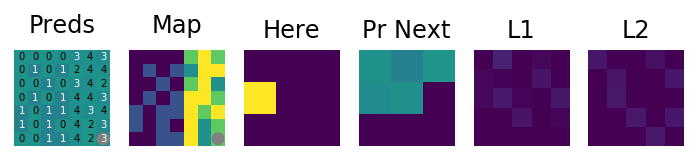

3/20: Avg L1 fb weight: 0.00157, avg L2 ff weight: 0.00175, loss - 0.25405678153038025


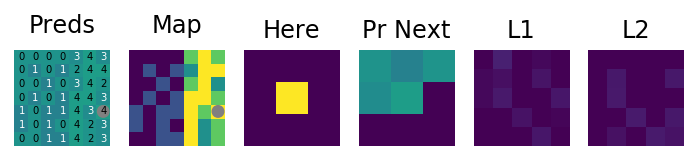

6/20: Avg L1 fb weight: 0.00055, avg L2 ff weight: 0.00062, loss - 0.24306686222553253


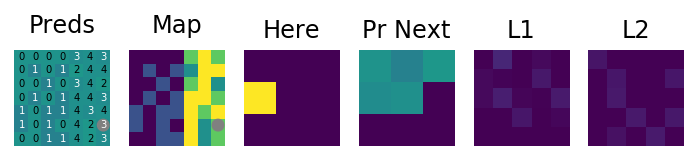

9/20: Avg L1 fb weight: 0.00027, avg L2 ff weight: 0.00027, loss - 0.2684137225151062


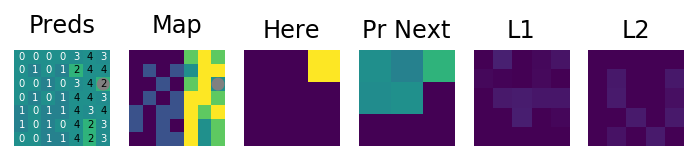

12/20: Avg L1 fb weight: 0.00017, avg L2 ff weight: 0.00018, loss - 0.24250420928001404


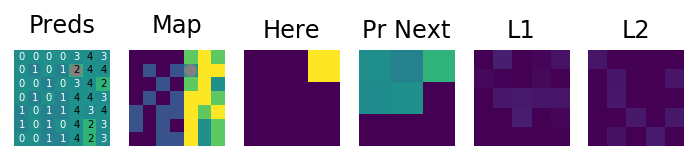

15/20: Avg L1 fb weight: 0.00014, avg L2 ff weight: 0.00014, loss - 0.25012752413749695


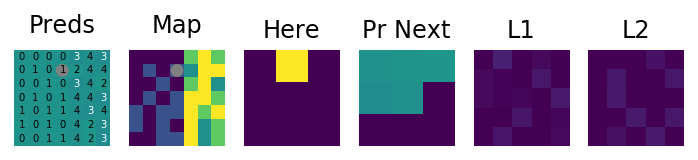

18/20: Avg L1 fb weight: 0.00013, avg L2 ff weight: 0.00013, loss - 0.2861494719982147


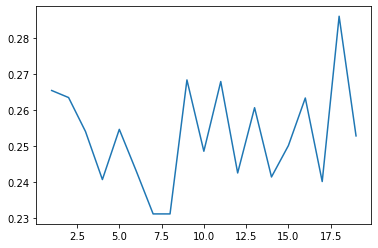

In [456]:
env = Environment()
net = Net(d_in=env.n_digits, 
          bsz=2,
          cells=5**2,
          sparsity=0.3,
          debug=False)
agent = Agents(net, env=env)

STEPS = 20
TEST_STEPS = 0
PLOT_INTERVAL = 3
PLOT_LOSS = True
SAVE_ANIM = False
PLOT_GRADS = False

losses = []

video = None

# Training (agent roams free for a while)
for t in range(STEPS):
    x = agent.move()

    agent.net._retie_weights()
    loss, predictions = agent.step(x, learning=True)
    losses.append(loss)
    
    if t and (t % PLOT_INTERVAL == 0 or SAVE_ANIM):
        fig = plot(predictions, agent, env, show=not SAVE_ANIM)
        if SAVE_ANIM:
            video = add_to_anim(video, fig, last=t == STEPS - 1)
        avg_l1_fb = agent.net.L1.linear_fb.module.weight.abs().mean()
        avg_l2_ff = agent.net.L2.linear_ff.module.weight.abs().mean()        
        if PLOT_GRADS:
            plot_grad_flow(agent.net)
            plt.show()
        print("%d/%d: Avg L1 fb weight: %.5f, avg L2 ff weight: %.5f, loss - %s" % (t, STEPS, avg_l1_fb, avg_l2_ff, loss))

if PLOT_LOSS:
    plt.plot(range(len(losses)), losses)
    plt.show()

In [ ]:
# Testing predictions from predetermined locations

x = agent.move(to=torch.tensor([1, 6]))
loss, predictions = agent.step(x, learning=False)
plot(predictions, agent, env, show=True)

### Analysis

Comparing learned FF and FB parameters post-training.

Semantics.

Spatial pooler (if allowed to), would develop similar representations of similar inputs? Useful for abstract predictions (via context), but not specific sequence orders. Relative importance of context vs sequence prediction depends on paradigm. In general, we'd like to perform both simultaneously, and be able to shift between a sequence-free prediction (context only), as well as detect subsequences within a given context when sequential stimuli are present.

Sensorimotor...

#### Degeneracy

It's possible to learn degenerate cases since we have a loop where feedback from L2(t-1) is input to L1(t), and L1(t-1) is input into L2(t-1). This loop is the very nature of the bidirectional connections taken as the premise... How to overcome it?

### Sequence prediction & lateral connections

### Relationship to grid cells & locations

Learning a spatial representation of context...

### Relationship to cortical columns

Similar, but inverse to canonincal column? Group of cells at L1 learn bidirectional connections with smaller group of cells in L2. Proximal connections taking feedback from above?

### Helper Functions

In [444]:
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2

def plot(predictions, agent, env, show=False, batch_id=0):
    """
    Plot environment/agent state for one item in batch
    """
    fig, axs = plt.subplots(1, 6, dpi=144)
    mapped_predictions = torch.zeros_like(env.data).float()
    landscape = env.data.t()
    predictions = predictions.detach()
    thresh = 0.5
    eps = 0.2
    for i in range(env.h):
        for j in range(env.w):
            val = landscape[i, j].item()
            p = predictions[batch_id][int(val)]  # From encoded pred
            mapped_predictions[i, j] = p
            c = "white" if p < thresh else "black"
            axs[0].text(i-eps, j+eps, str(val), color=c, fontsize=5)
    agent_c = Circle((agent.location[batch_id, 1], agent.location[batch_id, 0]), 0.4, color="gray")
    axs[0].add_patch(agent_c)
    axs[0].matshow(mapped_predictions.t(), vmin=0, vmax=1)
    axs[0].set_title("Preds")

    agent_c_map = Circle((agent.location[batch_id, 1], agent.location[batch_id, 0]), 0.4, color="gray")
    axs[1].matshow(landscape.t())
    axs[1].set_title("Map")
    axs[1].add_patch(agent_c_map)
    
    x = env.sense(agent.location)[batch_id]
    axs[2].imshow(activity_square(x), vmin=0, vmax=1)
    axs[2].set_title("Here")    
    axs[3].imshow(activity_square(predictions[batch_id]), vmin=0, vmax=1)
    axs[3].set_title("Pr Next")
    
    hidden = agent.buffer_hidden[-1]
    x_bs, = hidden
    x_bs.detach_()
    axs[4].imshow(activity_square(x_bs[0, batch_id]), vmin=0, vmax=1)
    axs[4].set_title("L1")

    axs[5].imshow(activity_square(x_bs[1, batch_id]), vmin=0, vmax=1)
    axs[5].set_title("L2")    
    for ax in axs:
        ax.axis("off")    
    if show:
        plt.show()
    return fig

def square_size(n):
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    return side

def activity_square(vector):
    n = len(vector)
    side = square_size(n)
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)

def debug_log(tensor_dict, truncate_len=400):
    for name, t in tensor_dict.items():
        if isinstance(t, torch.Tensor):
            t = t.detach().squeeze()
            if t.dim() == 1:
                t = t.flatten()
                size = t.numel()
                plt.imshow(activity_square(t))
                tmin = t.min()
                tmax = t.max()
                tsum = t.sum()
                plt.title(
                    "%s (%s, rng: %.3f-%.3f, sum: %.3f)"
                    % (name, size, tmin, tmax, tsum)
                )
                plt.show()

def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def plot_grad_flow(model, top=0.01):
    """
    Plots the gradients flowing through different layers in the net during
    training. Can be used for checking for possible gradient
    vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    """
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            zg = False
            if p.grad is not None:
                pmax = p.grad.abs().max()
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(pmax)
                zg = pmax == 0
            else:
                ave_grads.append(0)
                max_grads.append(0)
                zg = True
            if zg:
                n += " *"
            layers.append(n)
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=top)  # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow (* indicates 0 grad)")
    plt.grid(True)
    LABELS = ["max-gradient", "mean-gradient", "zero-gradient"]
    plt.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4),
        ],
        LABELS
    )

def fig2img(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()

    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.fromstring(canvas.tostring_rgb(), dtype="uint8").reshape(
        int(height), int(width), 3
    )
    return img

def add_to_anim(video, fig, image_folder='./snapshots', video_name='stiched.avi', last=False):
    frame = fig2img(fig)
    
    if video is None:
        height, width, layers = frame.shape
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        video = cv2.VideoWriter(video_name, fourcc, 5.0, (width,height))

    video.write(frame)

    if last:
        print("Saving %s" % video_name)
        cv2.destroyAllWindows()
        video.release() 
    return video